# Teste Prático (Engenheiro de Dados) - Matheus Freitas Martins

1. O proprietário da loja quer conhecer melhor de onde vem suas receitas. Criar visualizações que ajudem a responder aos seguintes questionamentos:
- a) Quais são os melhores clientes da loja?
- b) Quais são os melhores produtos da loja?
- c) Qual é o comportamento diário das vendas em termos de volume, faturamento e produtos vendidos?
- d) Como os diferentes países se comparam?

2. O proprietário da loja quer segmentar melhor os seus clientes para realizar campanhas de marketing. Elabore uma solução para criar três grupos de clientes com base nas características observadas em cada um deles. Apresente a solução e justifique suas decisões.

# Importanto as dependências

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport

%matplotlib inline

In [24]:
!pip install -U ydata-profiling

# Carregando os dados

In [25]:
data = pd.read_excel("Retail DB.xlsx")

# Entendendo os dados

In [26]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [28]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [29]:
data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [30]:
# Contando campos com valor 0 em cada coluna
count_zero_fields = data.apply(lambda x: (x == 0).sum())

print("Quantidade de campos com valor 0 em cada coluna:")
print(count_zero_fields)

Quantidade de campos com valor 0 em cada coluna:
InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice      2515
CustomerID        0
Country           0
dtype: int64


In [31]:
# Verificando produtos com StockCode, mas sem descrição
products_with_stockcode_no_description = data[data['StockCode'].notnull() & data['Description'].isnull()]
products_with_stockcode_no_description = products_with_stockcode_no_description.shape[0]

print(f"Quantidade de produtos com StockCode, mas sem descrição: {products_with_stockcode_no_description}")

Quantidade de produtos com StockCode, mas sem descrição: 1454


In [32]:
profile = ProfileReport(data, title="Retail Data Profiling Report", explorative=True)
profile.to_file("retail_data_profiling_report_before.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Premissas a serem consideradas

- Pode haver linhas duplicadas no dataframe;

- Pode haver produtos com preço igual a 0;

- A coluna StockCode pode conter valores que não estão em letras maiúsculas ou podem ser de tipos diferentes de strings;

- A coluna Description pode conter valores nulos ou vazios que serão preenchidos com a string "Desconhecido";

- Pode haver valores nulos na coluna CustomerID;

- Pode haver valores negativos nas colunas UnitPrice e Quantity;

- Cada item vendido gera uma receita, que é calculada multiplicando-se as colunas Quantity e UnitPrice;

- A coluna InvoiceDate pode ser usada para extrair a parte da data (sem hora) em uma nova coluna InvoiceDay;

- A coluna InvoiceNo pode conter transações que indicam devolução e que devem ser removidos.

# Limpeza e manipulação dos dados

In [33]:
# Criando uma cópia do DataFrame
df = data.copy()

# Removendo linhas duplicadas
df.drop_duplicates(inplace=True)

# Removendo produtos com preço igual a 0
df = df.loc[df['UnitPrice'] != 0]

# Convertendo todos os valores na coluna 'StockCode' para strings e maiúsculas
df.loc[:, 'StockCode'] = df['StockCode'].astype(str).str.upper()

# Convertendo todos os valores na coluna 'Description' para strings
# Preenchendo os valores NaN e vazios com 'Desconhecido'
df.loc[:, 'Description'] = df['Description'].astype(str).apply(lambda x: 'Desconhecido' if pd.isna(x) or x == '' else x).str.strip()

# Removendo todas as linhas com valores NaN (nulos) na coluna 'CustomerID'
df.dropna(subset=['CustomerID'], inplace=True)

# Alterando todos os valores negativos nas colunas 'UnitPrice' e 'Quantity' para positivos
df.loc[:, 'UnitPrice'] = df['UnitPrice'].apply(abs)
df.loc[:, 'Quantity'] = df['Quantity'].apply(abs)

# Calculando o faturamento gerado por cada item vendido e extrair a parte da data (sem hora) da coluna 'InvoiceDate'
# Representação do valor total de cada venda (quantidade * preço unitário)
df.loc[:, 'Revenue'] = df['Quantity'] * df['UnitPrice']
df.loc[:, 'InvoiceDay'] = df['InvoiceDate'].dt.date

# Mantendo apenas as linhas do DataFrame onde o número de Invoice não começa com "C" (transações canceladas).
df = df[df['InvoiceNo'].astype(str).str[0] != 'C']

In [34]:
#profile = ProfileReport(df, title="Retail Data Profiling Report", explorative=True)
#profile.to_file("retail_data_profiling_report_after.html")

# 1.

## a) Melhores clientes por receita

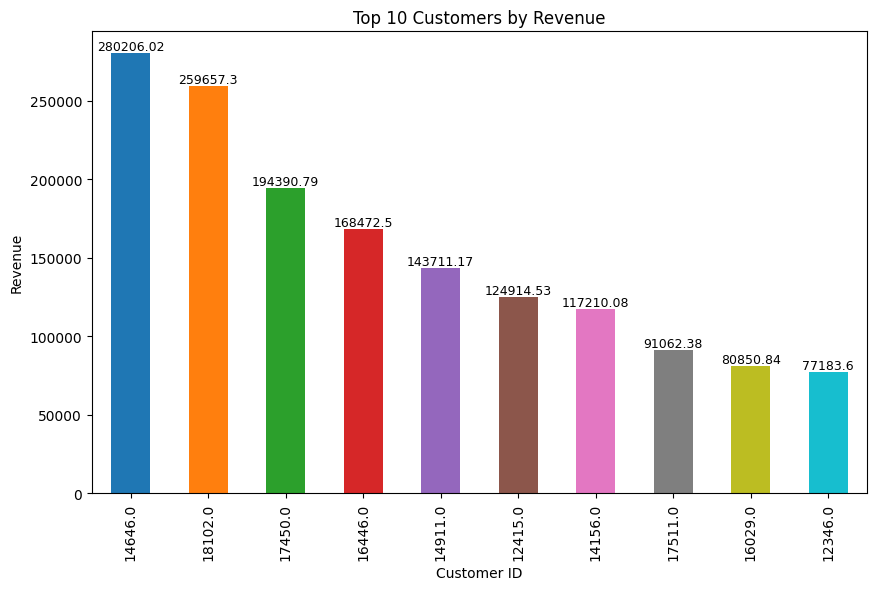

In [35]:
# Identificando os 10 principais clientes em termos de receita gerada
top_customers = df.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6), dpi=100)

colors = plt.cm.tab10(np.linspace(0, 1, len(top_customers)))
ax = top_customers.plot(kind='bar', color=colors)
plt.xlabel('Customer ID')
plt.ylabel('Revenue')
plt.title('Top 10 Customers by Revenue')

# Adicionando valores de receita em cada barra do gráfico
for i, value in enumerate(top_customers):
    ax.text(i, value, round(value, 2), ha='center', va='bottom', fontsize=9)

plt.show()

## b) Melhores produtos por receita e quantidade vendida

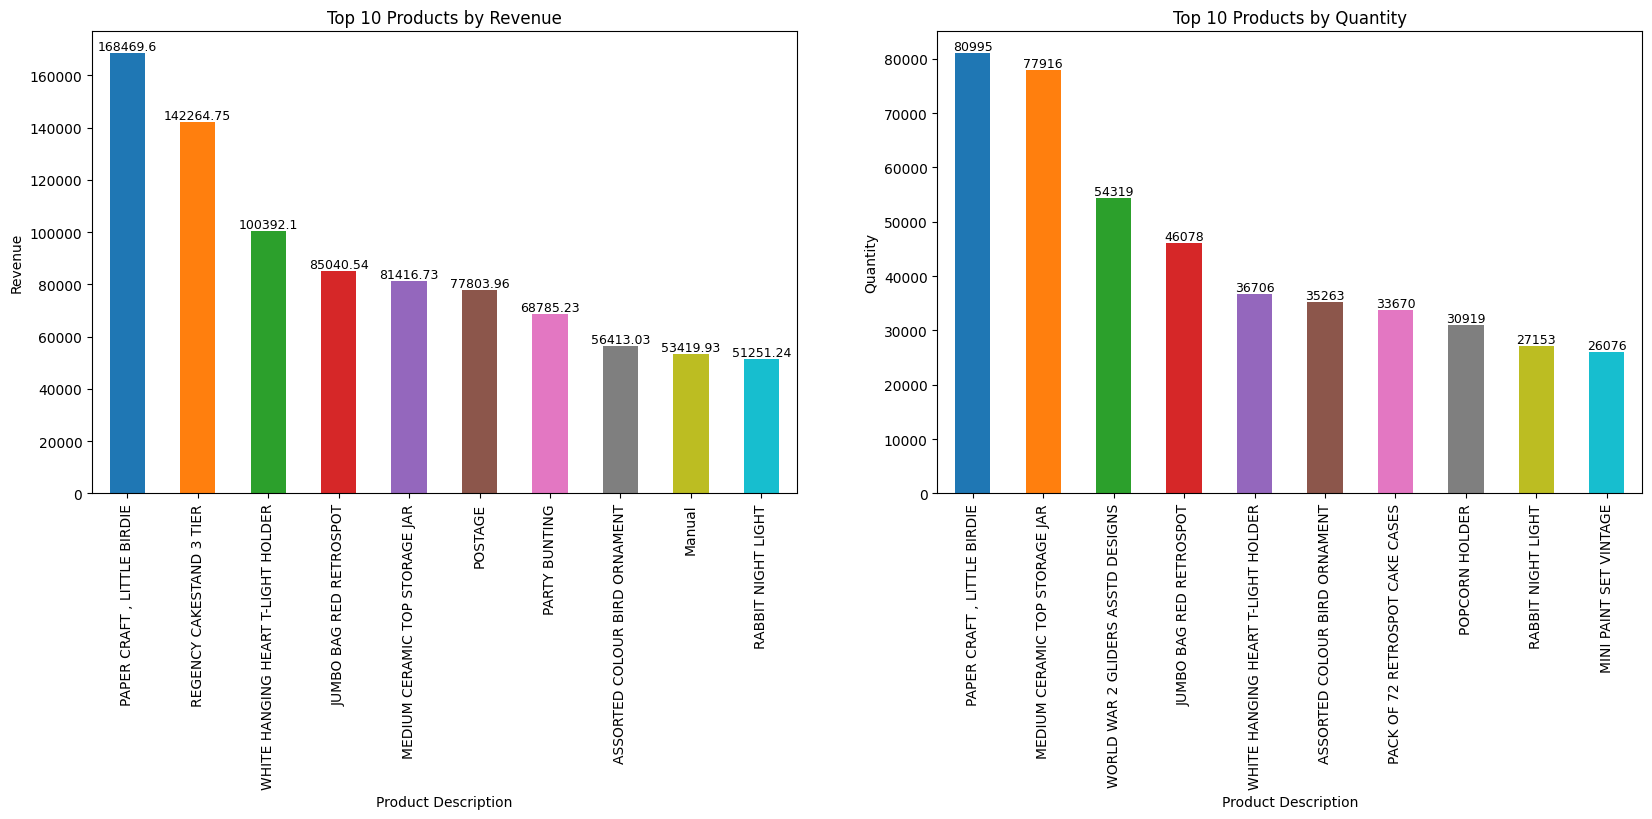

In [36]:
# Identificando os 10 produtos mais vendidos em termos de receita e quantidade. 
top_products_revenue = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10) # produtos com maires receita
top_products_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10) # produtos com maior quantidade vendida

# Ajustando o tamanho da figura e a resolução (dpi)
plt.figure(figsize=(20, 6), dpi=100)

# Definindo as cores usando um mapa de cores
colors = plt.cm.tab10(np.linspace(0, 1, len(top_products_revenue)))

# Gráfico de receita
plt.subplot(1, 2, 1)
ax1 = top_products_revenue.plot(kind='bar', color=colors)
plt.xlabel('Product Description')
plt.ylabel('Revenue')
plt.title('Top 10 Products by Revenue')

# Adicionando valores de receita em cada barra do gráfico
for i, value in enumerate(top_products_revenue):
    ax1.text(i, value, round(value, 2), ha='center', va='bottom', fontsize=9)

# Gráfico de quantidade
plt.subplot(1, 2, 2)
ax2 = top_products_quantity.plot(kind='bar', color=colors)
plt.xlabel('Product Description')
plt.ylabel('Quantity')
plt.title('Top 10 Products by Quantity')

# Adicionando valores de quantidade em cada barra do gráfico
for i, value in enumerate(top_products_quantity):
    ax2.text(i, value, value, ha='center', va='bottom', fontsize=9)

plt.show()

In [37]:
# Melhores produtos
top_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
print("Top 10 products:\n", top_products)


Top 10 products:
 Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142264.75
WHITE HANGING HEART T-LIGHT HOLDER    100392.10
JUMBO BAG RED RETROSPOT                85040.54
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68785.23
ASSORTED COLOUR BIRD ORNAMENT          56413.03
Manual                                 53419.93
RABBIT NIGHT LIGHT                     51251.24
Name: Revenue, dtype: float64


## c) Comportamento diário das vendas

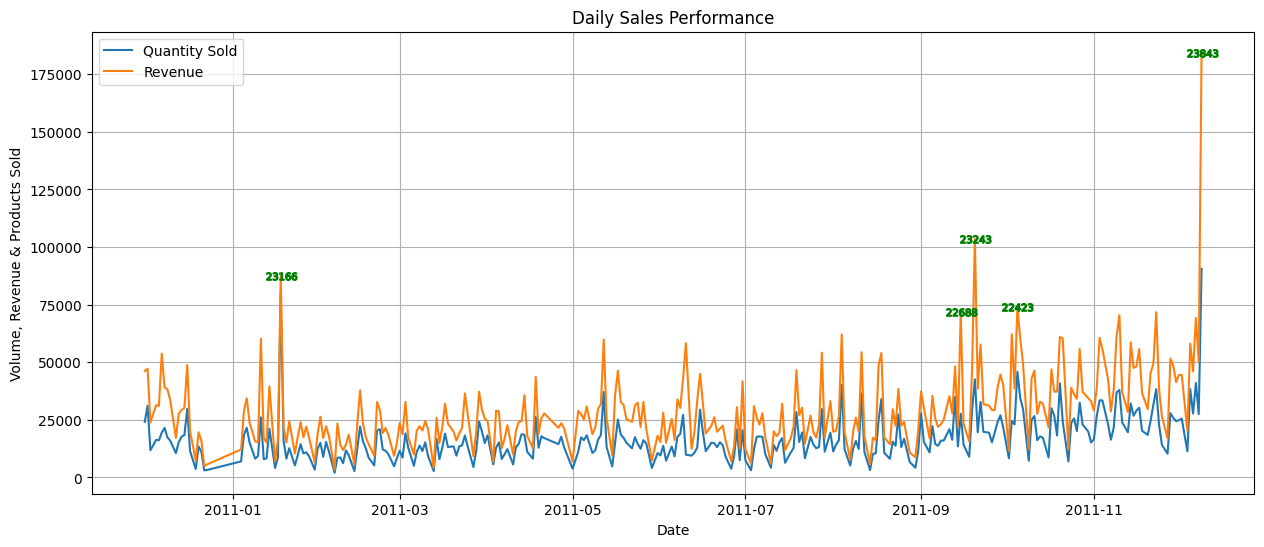

In [38]:
# Agrupando os dados por dia de fatura (InvoiceDay), calcula a soma das quantidades vendidas e da receita, e conta o número de itens para cada dia
daily_sales = df.groupby('InvoiceDay').agg({'Quantity': 'sum', 'Revenue': 'sum', 'Description': 'count'}).reset_index()

# Encontrando os dias com maior receita diária
top_revenue_days = daily_sales.nlargest(5, 'Revenue')

# Encontrando o produto (StockCode) com a maior receita nesses dias
top_stockcodes = []
for day in top_revenue_days['InvoiceDay']:
    top_product = df[df['InvoiceDay'] == day].nlargest(1, 'Revenue')
    top_stockcodes.append(top_product.iloc[0]['StockCode'])

# Ajustando o tamanho da figura e a resolução (dpi)
plt.figure(figsize=(15, 6), dpi=100)

plt.plot(daily_sales['InvoiceDay'], daily_sales['Quantity'], label='Quantity Sold')
plt.plot(daily_sales['InvoiceDay'], daily_sales['Revenue'], label='Revenue')

# Adicionando pontos de maior receita diária com o StockCode como marcador
for i, day in enumerate(top_revenue_days['InvoiceDay']):
    revenue = top_revenue_days.loc[top_revenue_days['InvoiceDay'] == day, 'Revenue'].values[0]
    plt.scatter(day, revenue, marker=f"${top_stockcodes[i]}$", s=500, c='green', zorder = 10)  
    
plt.xlabel('Date')
plt.ylabel('Volume, Revenue & Products Sold')
plt.title('Daily Sales Performance')

plt.legend()
plt.grid()
plt.show()


In [39]:
# Encontrando a descrição do produto com base no StockCode 
description = df.loc[df['StockCode'] == '23843', 'Description'].unique()

print("Descrição do produto:")
for desc in description:
    print(desc)


Descrição do produto:
PAPER CRAFT , LITTLE BIRDIE


## d) Comparação entre diferentes países

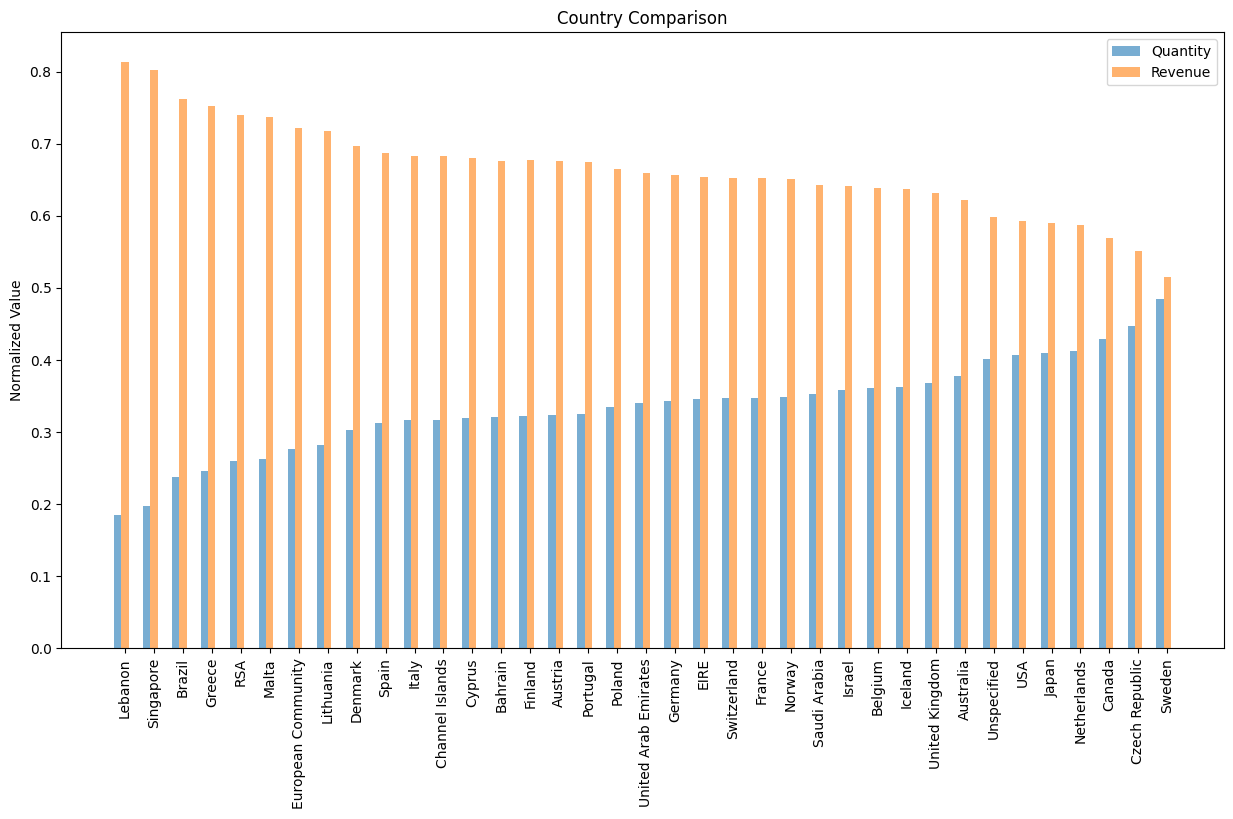

In [40]:
# Agrupando os dados por país. Para cada país, calcula a soma da coluna Quantity, a soma da coluna Revenue e a contagem única de valores da coluna CustomerID
country_sales = df.groupby('Country').agg({'Quantity': 'sum', 'Revenue': 'sum', 'CustomerID': pd.Series.nunique})

# Normalizando os dados de vendas por país
normalized_country_sales = country_sales.apply(lambda x: x / x.sum(), axis=1)

# Calculando a razão entre a receita e a quantidade para cada país
normalized_country_sales['Revenue_Quantity_Ratio'] = normalized_country_sales['Revenue'] / normalized_country_sales['Quantity']

# Ordenando os dados pela coluna Revenue_Quantity_Ratio em ordem decrescente
sorted_normalized_country_sales = normalized_country_sales.sort_values('Revenue_Quantity_Ratio', ascending=False)

# Plotando o gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(sorted_normalized_country_sales))
width = 0.25

ax.bar(x - width, sorted_normalized_country_sales['Quantity'], width, label='Quantity', alpha=0.6)
ax.bar(x, sorted_normalized_country_sales['Revenue'], width, label='Revenue', alpha=0.6)

ax.set_xticks(x)
ax.set_xticklabels(sorted_normalized_country_sales.index, rotation=90)
ax.set_ylabel('Normalized Value')
ax.set_title('Country Comparison')
ax.legend()

plt.show()


In [41]:
# Exibindo os valores de Quantity e Revenue para cada país
# Razão entre a quantidade normalizada e a receita normalizada de cada país.
sorted_normalized_country_sales['Revenue_Quantity_Ratio'] = sorted_normalized_country_sales['Revenue'] / sorted_normalized_country_sales['Quantity']
sorted_country_data = sorted_normalized_country_sales[['Quantity', 'Revenue', 'Revenue_Quantity_Ratio']]
print(sorted_country_data)


                      Quantity   Revenue  Revenue_Quantity_Ratio
Country                                                         
Lebanon               0.185498  0.814021                4.388290
Singapore             0.197615  0.802347                4.060158
Brazil                0.237238  0.762095                3.212360
Greece                0.246302  0.753066                3.057495
RSA                   0.259173  0.740089                2.855584
Malta                 0.262333  0.737126                2.809887
European Community    0.277184  0.722261                2.605711
Lithuania             0.281756  0.717812                2.547638
Denmark               0.302765  0.696904                2.301802
Spain                 0.312025  0.687639                2.203793
Italy                 0.316761  0.682693                2.155232
Channel Islands       0.316858  0.682841                2.155038
Cyprus                0.319382  0.680215                2.129787
Bahrain               0.3

# 2.

## Três grupos de clientes

No trecho abaixo, está sendo agrupando os dados por **CustomerID** e calculando quatro métricas para cada cliente: **Frequency**, **Total_Quantity**, **Total_Revenue** e **Recency**. Essas métricas nos ajudarão a entender o comportamento de compra dos clientes e a segmentá-los em diferentes grupos.

* **Frequency:** o número total de compras feitas por um cliente, calculado usando o número de **InvoiceNo** únicos.
* **Total_Quantity:** a quantidade total de itens comprados pelo cliente, calculada somando a coluna **Quantity**.
* **Total_Revenue:** a soma das receitas geradas pelo cliente, calculada somando a coluna **Revenue**.
* **Recency:** o número de dias desde a última compra do cliente, calculado usando o número de **InvoiceDay** únicos.

In [42]:
# Segmentação dos clientes
customer_data = df.groupby('CustomerID').agg({'InvoiceNo': pd.Series.nunique, 'Quantity': 'sum', 'Revenue': 'sum', 'InvoiceDay': pd.Series.nunique})
customer_data.columns = ['Frequency', 'Total_Quantity', 'Total_Revenue', 'Recency']

# Normalizando os dados 
scaler = StandardScaler()
customer_data_normalized = scaler.fit_transform(customer_data)

# Aplicando o algoritmo K-means para segmentar os clientes em três grupos. 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_normalized)

# Exibindo estatísticas descritivas para cada um dos três clusters.
for i in range(3):
    print(f"Cluster {i} statistics:")
    print(customer_data[customer_data['Cluster'] == i].describe())
    print()

Cluster 0 statistics:
        Frequency  Total_Quantity  Total_Revenue     Recency  Cluster
count  291.000000      291.000000     291.000000  291.000000    291.0
mean    19.079038     5198.841924    9211.794364   16.687285      0.0
std     10.522420     5598.582788    9552.290159    8.999721      0.0
min      3.000000      283.000000    1296.440000    2.000000      0.0
25%     13.000000     2164.000000    4116.590000   12.000000      0.0
50%     16.000000     3529.000000    6065.690000   14.000000      0.0
75%     21.000000     5662.000000   10290.750000   18.500000      0.0
max     93.000000    33704.000000   65164.790000   89.000000      0.0

Cluster 1 statistics:
         Frequency  Total_Quantity  Total_Revenue      Recency  Cluster
count  4030.000000     4030.000000    4030.000000  4030.000000   4030.0
mean      2.924069      631.184367    1065.193346     2.752109      1.0
std       2.329772      859.633555    1456.208257     2.118092      0.0
min       1.000000        1.000000   

**Cluster 0: Clientes de médio valor**

- Esses clientes têm uma frequência de compras moderada (média de 19 vezes) e compram uma quantidade razoável de produtos (média de 5198 unidades).
- Eles geram uma receita média de 9211,79 por cliente.
- A recência média é de 16,69 dias, o que indica que eles fizeram compras recentemente.
- Esse grupo representa uma base sólida de clientes que fornecem receita consistente.

**Cluster 1: Clientes de baixo valor**

- Esses clientes compram com pouca frequência (média de 2,92 vezes) e em quantidades menores (média de 631 unidades).
- Eles geram uma receita média de 1065,19 por cliente.
- A recência média é de 2,75 dias, o que indica que a maioria desses clientes fez uma compra muito recentemente.
- Este grupo representa uma grande quantidade de clientes, mas seu valor para a empresa é menor, já que suas compras são esporádicas e em menor volume.

**Cluster 2: Clientes de alto valor**

- Esses clientes têm uma alta frequência de compras (média de 70,35 vezes) e compram grandes quantidades de produtos (média de 64439 unidades).
- Eles geram uma receita média muito alta de 112579,27 por cliente.
- A recência média é de 48 dias, o que indica que eles não compraram tão recentemente quanto os outros dois grupos, mas ainda assim são clientes regulares.
- Este grupo é composto por um número menor de clientes (apenas 17), mas são extremamente valiosos para a empresa devido ao alto volume de compras e receita gerada.

Em resumo:

- O **Cluster 0** representa clientes de médio porte que compram com frequência moderada e geram uma receita média.
- O **Cluster 1** representa clientes ocasionais que compram com baixa frequência e geram uma receita menor.
- O **Cluster 2** representa grandes clientes que compram com **alta frequência e geram uma receita significativa**.

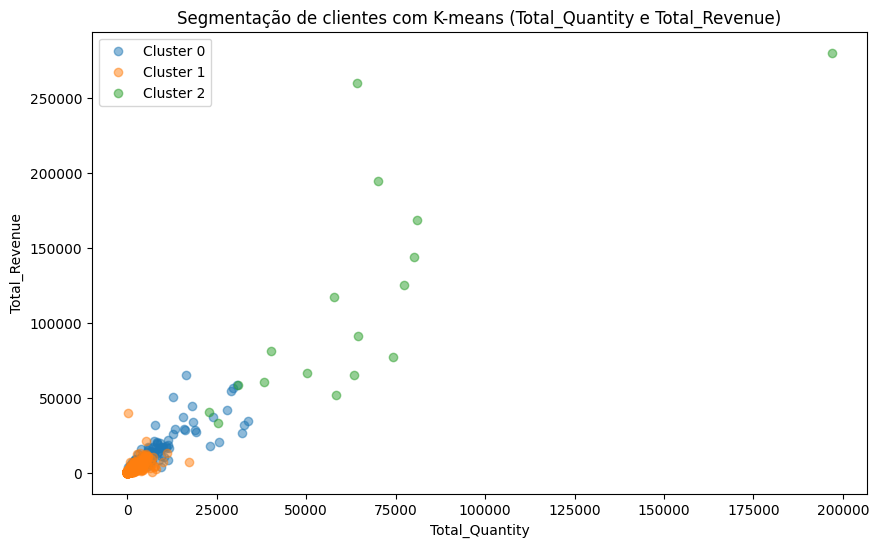

In [43]:
plt.figure(figsize=(10, 6))
for i in range(3):
    cluster_data = customer_data[customer_data['Cluster'] == i]
    plt.scatter(cluster_data['Total_Quantity'], cluster_data['Total_Revenue'], label=f'Cluster {i}', alpha=0.5)

plt.xlabel('Total_Quantity')
plt.ylabel('Total_Revenue')
plt.legend()
plt.title('Segmentação de clientes com K-means (Total_Quantity e Total_Revenue)')
plt.show()


In [44]:
# Exportando os clientes de cada Cluster em arquivos .csv
for i in range(3):
    cluster_customers = customer_data[customer_data['Cluster'] == i].index.values
    cluster_df = pd.DataFrame(cluster_customers, columns=['CustomerID'])
    cluster_df.to_csv(f'cluster_{i}_customers.csv', index=False)
    print(f"Clientes no Cluster {i} salvos em cluster_{i}_customers.csv")


Clientes no Cluster 0 salvos em cluster_0_customers.csv
Clientes no Cluster 1 salvos em cluster_1_customers.csv
Clientes no Cluster 2 salvos em cluster_2_customers.csv
